In [ ]:
# Ch13-2-barcodes

Sample of barcode-gene mapping:
AAGCCCAATAAA -> Gene_A1
CCACTCTGACTG -> Gene_A2
GCCGAATAGGGA -> Gene_A3
TATAGGCAACGA -> Gene_A4
CATGTGCGGCGA -> Gene_B1
...
Generated 3000 reads for Sample_1
Generated 3000 reads for Sample_2
Generated 3000 reads for Sample_3

Analysis of Sample_1:
  Total reads: 3000
  Reads with identified barcodes: 3000 (100.0%)
  Unique genes detected: 42
  Top 5 most abundant genes:
    Gene_E1: 1092 reads (36.4%)
    Gene_G1: 349 reads (11.6%)
    Gene_G2: 190 reads (6.3%)
    Gene_M2: 142 reads (4.7%)
    Gene_K2: 125 reads (4.2%)

Analysis of Sample_2:
  Total reads: 3000
  Reads with identified barcodes: 3000 (100.0%)
  Unique genes detected: 46
  Top 5 most abundant genes:
    Gene_E3: 469 reads (15.6%)
    Gene_L2: 262 reads (8.7%)
    Gene_K2: 215 reads (7.2%)
    Gene_H2: 176 reads (5.9%)
    Gene_M2: 172 reads (5.7%)

Analysis of Sample_3:
  Total reads: 3000
  Reads with identified barcodes: 3000 (100.0%)
  Unique genes detected: 45
  Top 5 most abundant g

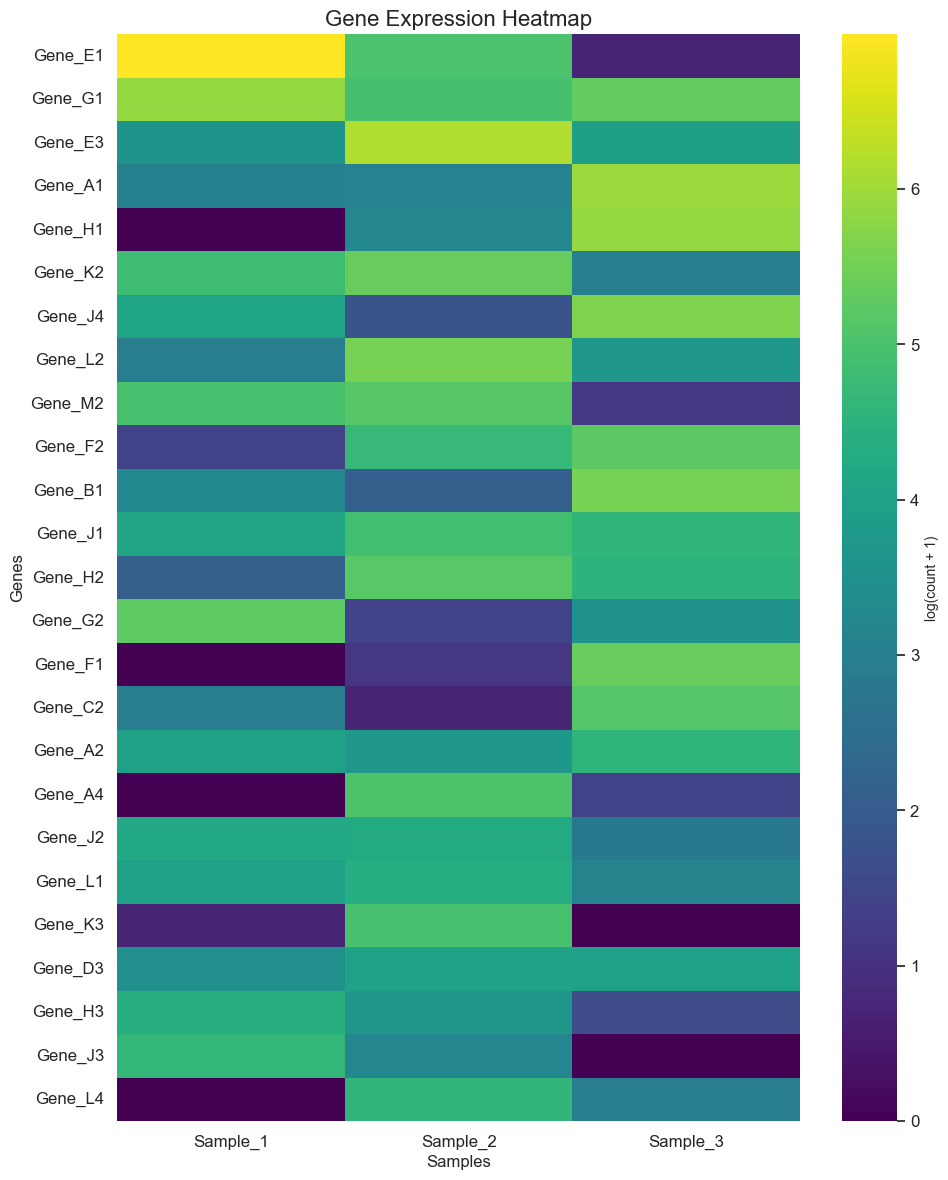

<Figure size 1200x800 with 0 Axes>

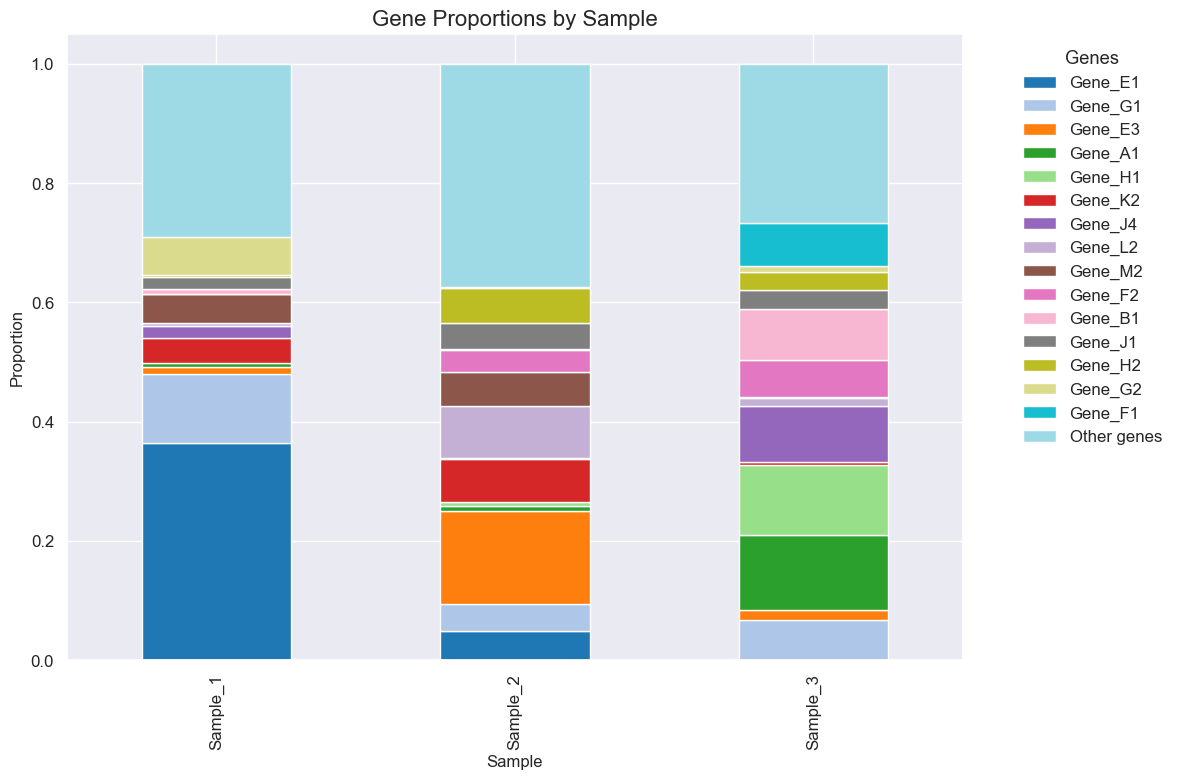

<Figure size 1200x800 with 0 Axes>

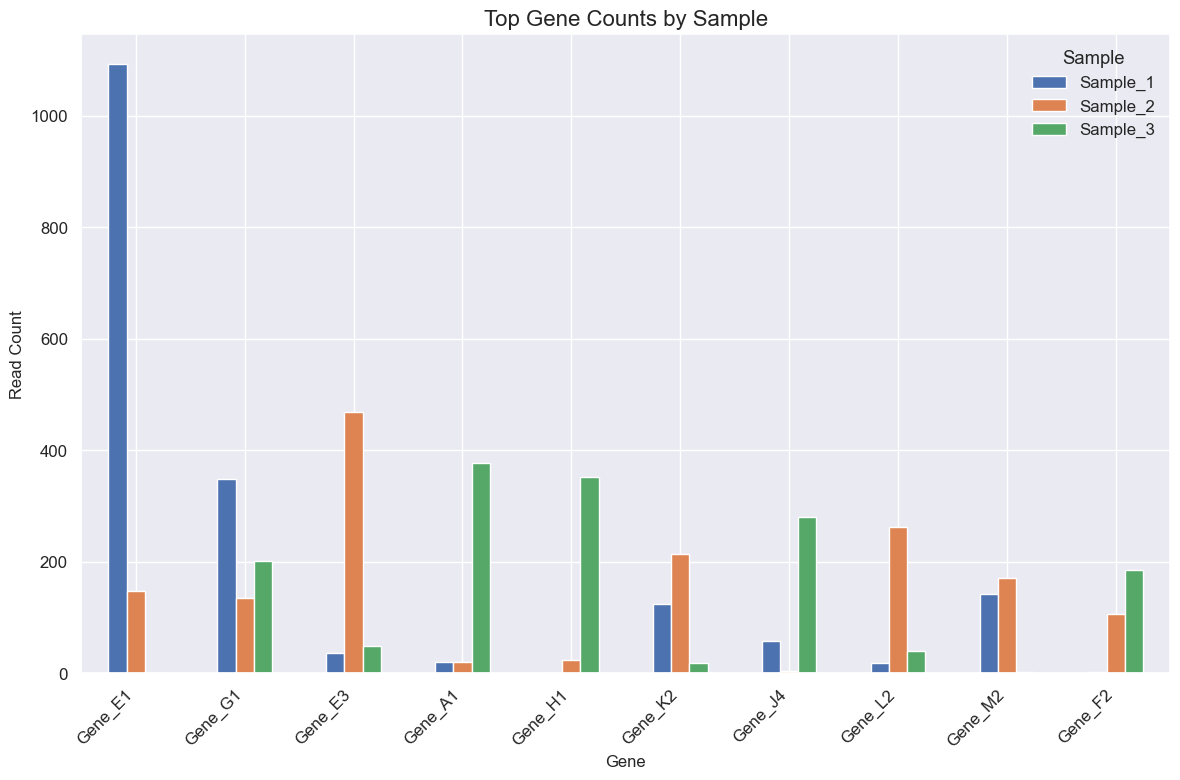

Analysis complete!


In [56]:

# Barcode Analysis in FASTQ Files 

import re
import random
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set style for plots
plt.style.use('ggplot')
sns.set(font_scale=1.1)

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

# Step 1: Define functions to generate simulated FASTQ data

def generate_random_sequence(length):
    """Generate a random DNA sequence of specified length"""
    return ''.join(random.choice('ACGT') for _ in range(length))

def create_barcode_gene_map(num_barcodes=50):
    """Create a mapping between barcodes and genes"""
    genes = [f"Gene_{chr(65+i//4)}{i%4+1}" for i in range(num_barcodes)]  # Generate gene names like A1, A2, B1, etc.
    barcodes = [generate_random_sequence(12) for _ in range(num_barcodes)]  # 12-bp barcodes
    
    return dict(zip(barcodes, genes))

def generate_fastq_content(num_reads, barcode_gene_map, barcode_distribution):
    """
    Generate content for a simulated FASTQ file with barcoded reads
    Returns a list of lines that would be in a FASTQ file
    """
    barcodes = list(barcode_gene_map.keys())
    lines = []
    
    for i in range(num_reads):
        # Select a barcode based on the provided distribution
        barcode = np.random.choice(barcodes, p=barcode_distribution)
        
        # Create a read with the barcode at a fixed position
        pre_seq = generate_random_sequence(random.randint(15, 25))
        post_seq = generate_random_sequence(random.randint(30, 60))
        full_seq = pre_seq + barcode + post_seq
        
        # Generate quality scores (dummy values)
        quality = ''.join(chr(random.randint(33, 73)) for _ in range(len(full_seq)))
        
        # Add FASTQ entry
        lines.append(f"@Read_{i+1} barcode={barcode}")
        lines.append(full_seq)
        lines.append("+")
        lines.append(quality)
    
    return lines

def create_sample_distributions(num_barcodes, num_samples=3):
    """Create different probability distributions for barcode sampling in each sample"""
    distributions = []
    
    for sample in range(num_samples):
        # Create a biased distribution - some genes will be more frequent in each sample
        dist = np.random.dirichlet(np.ones(num_barcodes) * 0.5)
        
        # Add additional bias to make samples more distinct
        boost_indices = np.random.choice(num_barcodes, size=5, replace=False)
        for idx in boost_indices:
            dist[idx] *= random.uniform(3, 8)
        
        # Normalize to sum to 1
        dist = dist / dist.sum()
        distributions.append(dist)
    
    return distributions

# Step 2: Define functions to parse and analyze FASTQ data

def parse_fastq(fastq_lines):
    """Parse FASTQ content and return the read_id and sequence for each entry"""
    reads = []
    for i in range(0, len(fastq_lines), 4):
        if i+3 < len(fastq_lines):
            header = fastq_lines[i].strip()
            sequence = fastq_lines[i+1].strip()
            reads.append((header, sequence))
    
    return reads

def extract_barcodes(reads, barcode_pattern):
    """Extract barcodes from reads using a regex pattern"""
    barcode_dict = {}
    
    for header, sequence in reads:
        read_id = header.split()[0][1:]  # Remove '@' prefix
        
        # Try to extract from header if available
        header_match = re.search(r'barcode=(\w+)', header)
        if header_match:
            barcode_dict[read_id] = header_match.group(1)
            continue
            
        # Otherwise extract from the sequence
        match = barcode_pattern.search(sequence)
        if match:
            barcode_dict[read_id] = match.group(1)
    
    return barcode_dict

def map_to_genes_and_count(barcode_dict, barcode_gene_map):
    """Map barcodes to genes and count occurrences"""
    # Count barcodes
    barcode_counts = Counter(barcode_dict.values())
    
    # Map to genes and aggregate counts
    gene_counts = defaultdict(int)
    for barcode, count in barcode_counts.items():
        if barcode in barcode_gene_map:
            gene = barcode_gene_map[barcode]
            gene_counts[gene] += count
    
    return Counter(gene_counts)

# Step 3: Define functions for visualization

def plot_gene_heatmap(sample_results, title="Gene Expression Heatmap"):
    """Create a heatmap of gene expression across samples"""
    # Convert to DataFrame for easier plotting
    all_genes = sorted(set().union(*[counts.keys() for counts in sample_results.values()]))
    df = pd.DataFrame(index=all_genes)
    
    for sample, counts in sample_results.items():
        df[sample] = pd.Series(counts)
    
    # Fill NAs with zeros
    df = df.fillna(0)
    
    # Sort by total counts across all samples
    df['total'] = df.sum(axis=1)
    df = df.sort_values('total', ascending=False).drop('total', axis=1)
    
    # Keep top 25 genes for better visualization
    df = df.head(25)
    
    # Create heatmap
    plt.figure(figsize=(10, 12))
    
    # Normalize data for better visualization (log scale)
    norm_df = np.log1p(df)  # log(1+x) to handle zeros
    
    # Create heatmap
    sns.heatmap(norm_df, cmap="viridis", annot=False)
    plt.title(title, fontsize=16)
    plt.ylabel("Genes", fontsize=12)
    plt.xlabel("Samples", fontsize=12)
    
    # Add colorbar label
    cbar = plt.gcf().axes[-1]
    cbar.set_ylabel('log(count + 1)', fontsize=10)
    
    plt.tight_layout()
    plt.show()

def plot_gene_proportions(sample_results, title="Gene Proportions by Sample"):
    """Create a stacked bar chart showing gene proportions in each sample"""
    # Convert to DataFrame
    all_genes = sorted(set().union(*[counts.keys() for counts in sample_results.values()]))
    df = pd.DataFrame(index=all_genes)
    
    for sample, counts in sample_results.items():
        df[sample] = pd.Series(counts)
    
    # Fill NAs with zeros
    df = df.fillna(0)
    
    # Sort by total counts
    df['total'] = df.sum(axis=1)
    df = df.sort_values('total', ascending=False).drop('total', axis=1)
    
    # Convert to proportions
    prop_df = df.copy()
    for col in prop_df.columns:
        prop_df[col] = prop_df[col] / prop_df[col].sum()
    
    # Keep top 15 genes, combine others
    top_n = 15
    if len(prop_df) > top_n:
        top_genes = prop_df.head(top_n).index
        others_df = pd.DataFrame({
            col: [prop_df.loc[~prop_df.index.isin(top_genes), col].sum()] 
            for col in prop_df.columns
        }, index=['Other genes'])
        prop_df = pd.concat([prop_df.loc[top_genes], others_df])
    
    # Plot stacked bar chart
    plt.figure(figsize=(12, 8))
    prop_df.T.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab20')
    plt.title(title, fontsize=16)
    plt.xlabel("Sample", fontsize=12)
    plt.ylabel("Proportion", fontsize=12)
    plt.legend(title="Genes", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def plot_top_genes_barplot(sample_results, n=10, title="Top Gene Counts by Sample"):
    """Create a grouped bar chart for the top genes"""
    # Convert to DataFrame
    all_genes = sorted(set().union(*[counts.keys() for counts in sample_results.values()]))
    df = pd.DataFrame(index=all_genes)
    
    for sample, counts in sample_results.items():
        df[sample] = pd.Series(counts)
    
    # Fill NAs with zeros
    df = df.fillna(0)
    
    # Sort by total counts
    df['total'] = df.sum(axis=1)
    df = df.sort_values('total', ascending=False).drop('total', axis=1)
    
    # Keep top N genes
    top_genes = df.head(n)
    
    # Plot
    plt.figure(figsize=(12, 8))
    top_genes.plot(kind='bar', figsize=(12, 8))
    plt.title(title, fontsize=16)
    plt.xlabel("Gene", fontsize=12)
    plt.ylabel("Read Count", fontsize=12)
    plt.legend(title="Sample")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Now let's run the simulation and analysis

# Create barcode-gene mapping
num_barcodes = 50
barcode_gene_map = create_barcode_gene_map(num_barcodes)

# Display a few entries from the barcode-gene map
print("Sample of barcode-gene mapping:")
for i, (barcode, gene) in enumerate(list(barcode_gene_map.items())[:5]):
    print(f"{barcode} -> {gene}")
print("...")

# Create distributions for three different samples
sample_distributions = create_sample_distributions(num_barcodes, num_samples=3)

# Generate simulated FASTQ data
sample_fastq_data = {}
for i, dist in enumerate(sample_distributions):
    sample_name = f"Sample_{i+1}"
    sample_fastq_data[sample_name] = generate_fastq_content(num_reads=3000, 
                                                           barcode_gene_map=barcode_gene_map, 
                                                           barcode_distribution=dist)
    print(f"Generated {len(sample_fastq_data[sample_name])//4} reads for {sample_name}")

# Setup regex pattern for extracting barcodes
# In real data, you'd need to know where in the read your barcode is located
# Here we'll extract any 12-bp sequence, which is simplistic but works for our simulation
barcode_pattern = re.compile(r'([ACGT]{12})')

# Analyze each sample
sample_results = {}
for sample_name, fastq_lines in sample_fastq_data.items():
    # Parse FASTQ and extract barcodes
    reads = parse_fastq(fastq_lines)
    barcode_dict = extract_barcodes(reads, barcode_pattern)
    
    # Map barcodes to genes and count
    gene_counts = map_to_genes_and_count(barcode_dict, barcode_gene_map)
    
    # Store results
    sample_results[sample_name] = gene_counts
    
    # Print summary statistics
    print(f"\nAnalysis of {sample_name}:")
    print(f"  Total reads: {len(reads)}")
    print(f"  Reads with identified barcodes: {len(barcode_dict)} ({len(barcode_dict)/len(reads)*100:.1f}%)")
    print(f"  Unique genes detected: {len(gene_counts)}")
    print(f"  Top 5 most abundant genes:")
    for gene, count in gene_counts.most_common(5):
        print(f"    {gene}: {count} reads ({count/len(reads)*100:.1f}%)")

# Create visualizations
print("\nGenerating visualizations...")

# Create heatmap
plot_gene_heatmap(sample_results)

# Create proportions plot
plot_gene_proportions(sample_results)

# Create top genes plot
plot_top_genes_barplot(sample_results)

print("Analysis complete!")